In [2]:
import os
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import pydicom
import tensorflow as tf
import re
import math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import gc
from datetime import datetime
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from keras_cv_attention_models import efficientnet

### Configs

In [2]:
class CFG:

    model_name = 'EfficientNetV2B0'

    batch_size = 8
    
    epochs = 1

    folds = 1

    seed = 123

    img_size = [512, 512]

    augment   = True

    transform_prob = 0.90
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 4.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 30.0
    wshift = 30.0

    hflip = True
    vflip = True

    p_pixel_aug = 0.90
    cont = [0.5, 2]
    bri  = 0.5

    clip = False

    drop_prob   = 0.6
    drop_cnt    = 10
    drop_size   = 0.05

    mixup_prob = 0.5
    mixup_alpha = 0.2
    
    cutmix_prob = 0.5
    cutmix_alpha = 2.5

    target_col  = [ "bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

### Seeding

In [3]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')

seeding(CFG.seed)

seeding done!!!


# DCM image to PNG

In [9]:
IMG_DIR = './Dataset/'

resize_dimension = 512
image_size = [resize_dimension, resize_dimension]
index = 0
parts = 1

### Process meta data
##### Adopt only data with 'injury_name' as training data.

In [18]:
df = pd.read_csv('./rsna2023atd_files/train.csv')
img_lvl_df = pd.read_csv('./rsna2023atd_files/image_level_labels.csv')
df = df.merge(img_lvl_df, on=['patient_id'], how='right')

df['image_path'] = (f'./rsna2023atd_files/train_images/'
                          + df.patient_id.astype(str)+ '/' 
                          + df.series_id.astype(str) + '/' 
                          + df.instance_number.astype(str) 
                          + '.dcm')

In [19]:
train, test = train_test_split(df['patient_id'], test_size=10, shuffle=True, random_state=123)

test.to_csv('test_data.csv', index=False)
test_list = test.tolist()

train_df = df.query('patient_id not in @test_list')
test_df = df.query('patient_id in @test_list')

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12024,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,155,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12025,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,156,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12026,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,157,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12027,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,158,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...


In [21]:
test_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,362,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,363,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,364,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,365,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,366,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11415,63665,0,1,0,1,1,0,0,1,0,0,1,0,0,1,19848,244,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
11416,63665,0,1,0,1,1,0,0,1,0,0,1,0,0,1,19848,245,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
11417,63665,0,1,0,1,1,0,0,1,0,0,1,0,0,1,19848,246,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
11418,63665,0,1,0,1,1,0,0,1,0,0,1,0,0,1,19848,247,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...


In [17]:
train_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path
105,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,37324,48,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
106,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,37324,49,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
107,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,37324,50,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
108,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,37324,51,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
109,10065,0,1,1,0,1,0,0,1,0,0,1,0,0,1,37324,52,Bowel,/kaggle/input/rsna-2023-abdominal-trauma-detec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12024,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,155,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12025,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,156,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12026,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,157,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...
12027,9632,1,0,0,1,1,0,0,1,0,0,1,0,0,1,3750,158,Active_Extravasation,/kaggle/input/rsna-2023-abdominal-trauma-detec...


### Convert .dcm to .png

In [52]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:

    
    # https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    # https://www.kaggle.com/code/theoviel/get-started-quicker-dicom-png-conversion
    # https://www.kaggle.com/code/alenic/dataset-size-reduction-400gb-to-7-5gb

    pixel_array = dcm.pixel_array

    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        # https://www.eizo.co.jp/products/tech/files/2004/wp_jp_04_001_grayscale.pdf
        # https://www.classcat.com/medical_ai/tag/pydicom-2-2-user-guide/
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    
    return pixel_array


# https://dicom.nema.org/medical/Dicom/2018d/output/chtml/part03/sect_C.7.6.3.html
def read_xray(file_path, fix_monochrome = True):

    dicom = pydicom.dcmread(file_path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
        
    return data


def resize_and_save(file_path):
    image = read_xray(file_path)
    height = image.shape[0]
    width = image.shape[1]
    image = cv2.resize(image, (resize_dimension, resize_dimension), cv2.INTER_LINEAR) # bilinear interpolation
    image = (image * 255).astype(np.uint8)

    sub_path = file_path.split('/')[-4] + '/' +file_path.split('/')[-3] + '/' + file_path.split('/')[-2] + '/' + file_path.split('/')[-1].split('.')[0] + '.png'

    infos = sub_path.split('/')
    patient_id = infos[1]
    series_id = infos[2]
    instance_id = infos[3] ; instance_id = instance_id.replace('.png', '')

    new_path = os.path.join(IMG_DIR, sub_path)
    os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)

    cv2.imwrite(new_path, image, [cv2.IMWRITE_PNG_COMPRESSION, 0])

    return patient_id,series_id,instance_id,width,height

In [53]:
%%time
from joblib import Parallel, delayed
file_paths = train_df.image_path.tolist()
# https://qiita.com/Jungle-King/items/1d332a91647a3d996b82
imagesize_train = Parallel(n_jobs=-1,backend='threading')(delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths, leave=True, position=0))

100%|██████████| 12029/12029 [00:56<00:00, 212.89it/s]


CPU times: user 1min 20s, sys: 13.3 s, total: 1min 33s
Wall time: 56.6 s


In [54]:
%%time
file_paths = test_df.image_path.tolist()
imagesize_test = Parallel(n_jobs=-1,backend='threading')(delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths))

100%|██████████| 3/3 [00:00<00:00, 8433.59it/s]

CPU times: user 24.6 ms, sys: 7.23 ms, total: 31.8 ms
Wall time: 35.9 ms


### Add 'image_path' to dataframes

In [55]:
pid, sid, iid, width, height = list(zip(*imagesize_train))

meta_df = pd.DataFrame({'patient_id'     : pid,
                        'series_id'      : sid,
                        'instance_number': iid,
                        'width'          : width,
                        'height'         : height})
meta_df[['patient_id', 'series_id', 'instance_number']] = meta_df[['patient_id', 'series_id', 'instance_number']].astype(int)

train_df = train_df.merge(meta_df, on=['patient_id','series_id','instance_number'], how='right')
train_df['image_path'] = f'./Dataset/train_images/' + \
                            train_df.patient_id.astype(str) + '/' + \
                            train_df.series_id.astype(str) + '/' + \
                            train_df.instance_number.astype(str) + '.png'

train_df.to_csv(f'{IMG_DIR}' + 'train.csv', index=False)

In [56]:
pid, sid, iid, width, height = list(zip(*imagesize_test))

test_meta_df = pd.DataFrame({'patient_id'     : pid,
                            'series_id'       : sid,
                            'instance_number' : iid,
                            'width'           : width,
                            'height'          : height})
test_meta_df[['patient_id', 'series_id', 'instance_number']] = test_meta_df[['patient_id', 'series_id', 'instance_number']].astype(int)

test_meta_df = test_df.merge(test_meta_df, on=['patient_id','series_id','instance_number'], how='right')
test_df['image_path'] = f'./Dataset/test_images/' + \
                            test_df.patient_id.astype(str) + '/' + \
                            test_df.series_id.astype(str) + '/' + \
                            test_df.instance_number.astype(str) + '.png'

test_df.to_csv(f'{IMG_DIR}' + 'test.csv', index=False)

### Prepare Dataframe

In [57]:
df = pd.read_csv('./Dataset/train.csv')
test_df = pd.read_csv('./Dataset/test.csv')

### Asign Fold numbers

In [58]:
df['stratify'] = ''

for col in CFG.target_col:
    df['stratify'] += df[col].astype(str)

df = df.reset_index(drop=True)

sgkf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(sgkf.split(df, df['stratify'], df['patient_id'])):
    df.loc[val_idx, 'fold'] = fold

display(df.groupby(['fold', 'patient_id']).size())

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=12.
  warnings.warn(


fold  patient_id
0.0   1758           30
      8263            4
      13241          38
      13403          33
      31636          14
                   ... 
11.0  50873          47
      51476          10
      51778          47
      53908         339
      62116         120
Length: 246, dtype: int64

### Data Augmentation

In [59]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)



def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)



# make affine transformation matrix
# https://cs.kwansei.ac.jp/prog1/affine.html
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):

    # degrees to radians
    shear = math.pi * shear / 180.


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')

    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, K.dot(zoom_matrix, shift_matrix))



# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    shear        = CFG.shr * tf.random.normal([1], dtype='float32')
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    # https://daeudaeu.com/reverse-matorix/
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 3])  

    return image



# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

    return image



# apply mixup amd cutmix to image
# https://cvml-expertguide.net/terms/dl/regularization/data-augmentation/
# mixup
def get_mixup(alpha, prob):
    
    
    # https://qiita.com/AseiSugiyama/items/66a75610c569a23ac493
    @tf.function
    def mixup(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        images = lamb * images + (1.0 - lamb) * tf.roll(images, shift=1, axis=0)
        labels = lamb * labels + (1.0 - lamb) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels
    
    return mixup



# cutmix
def get_cutmix(alpha, prob):


    @tf.function
    def cutmix(images, labels, alpha=alpha, prob=prob):

        if random_float() > prob:
            return images, labels
        
        image_shape = tf.shape(images)
        label_shape = tf.shape(labels) # label shape has (20,1) and (20,3) mixed in it so can't get the shape

        width = tf.cast(image_shape[2], tf.int32)
        height = tf.cast(image_shape[1], tf.int32)

        beta = tfp.distributions.Beta(alpha, alpha)
        lamb = beta.sample(1)[0]

        r_x = random_int([], minval=0, maxval=width)
        r_y = random_int([], minval=0, maxval=height)
        r = 0.5 * tf.math.sqrt(1.0 - lamb)
        r_w_half = tf.cast(r * tf.cast(width, tf.float32), tf.int32)
        r_h_half = tf.cast(r * tf.cast(height, tf.float32), tf.int32)

        x1 = tf.cast(tf.clip_by_value(r_x - r_w_half, 0, width), tf.int32)
        x2 = tf.cast(tf.clip_by_value(r_x + r_w_half, 0, width), tf.int32)
        y1 = tf.cast(tf.clip_by_value(r_y - r_h_half, 0, height), tf.int32)
        y2 = tf.cast(tf.clip_by_value(r_y + r_h_half, 0, height), tf.int32)

        # outer-pad patch -> [0, 0, 1, 1, 0, 0]
        patch1 = images[:, y1:y2, x1:x2, :]  # [batch, height, width, channel]
        patch1 = tf.pad(patch1, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])  # outer-pad

        # inner-pad patch -> [1, 1, 0, 0, 1, 1]
        patch2 = tf.roll(images, shift=1, axis=0)[:, y1:y2, x1:x2, :]
        patch2 = tf.pad(patch2, [[0, 0], [y1, height - y2], [x1, width - x2], [0, 0]])
        patch2 = tf.roll(images, shift=1, axis=0) - patch2  # inner-pad = img - outer-pad

        images = patch1 + patch2  # cutmix img

        lambda2 = tf.cast((1.0 - (x2 - x1) * (y2 - y1) / (width * height)), tf.float32)
        labels = lambda2 * labels + (1.0 - lambda2) * tf.roll(labels, shift=1, axis=0)

        images = tf.reshape(images, image_shape)
        labels = tf.reshape(labels, label_shape)

        return images, labels

    return cutmix

### Data pipeline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [60]:
def build_decoder(with_labels=True, target_size=CFG.img_size):


    def decode_image(path):

        file_binary = tf.io.read_file(path)
        image = tf.image.decode_png(file_binary, channels=3, dtype=tf.uint8)
        image = tf.image.resize(image, CFG.img_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*CFG.img_size, 3])

        return image
    

    def decode_label(label):
        
        label = tf.cast(label, tf.float32)
        
        return (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    def decode_with_labels(path, label):

        return decode_image(path), decode_label(label)

    return decode_with_labels if with_labels else decode_image
    


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform_prob:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image

        if random_float() < CFG.p_pixel_aug:
            image = tf.image.random_contrast(image, CFG.cont[0], CFG.cont[1])
            image = tf.image.random_brightness(image, CFG.bri)
        
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(image, [*DIM, 3])

        return image

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment



# https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
def build_dataset(paths, labels=None, batch_size=CFG.batch_size, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=False, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    # https://tensorflow.classcat.com/2019/03/23/tf20-alpha-guide-data-performance/
    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds

    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds

    if augment and labels is not None:
        ds = ds.map(lambda image, label: (dropout(image,
                                                  DIM=CFG.img_size, 
                                                  PROBABILITY=CFG.drop_prob, 
                                                  cutout=CFG.drop_cnt,
                                                  size=CFG.drop_size), label),num_parallel_calls=AUTO)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)

    
    #if augment and labels is not None:
    #    if CFG.cutmix_prob:
    #        ds = ds.map(get_cutmix(alpha=CFG.cutmix_alpha,prob=CFG.cutmix_prob),num_parallel_calls=AUTO)
    #    if CFG.mixup_prob:
    #        ds = ds.map(get_mixup(alpha=CFG.mixup_alpha,prob=CFG.mixup_prob),num_parallel_calls=AUTO)
    

    ds = ds.prefetch(AUTO)

    return ds

### Build Model

In [61]:
def build_model(model_name=CFG.model_name, dim=CFG.img_size):


        # backbone
        base = getattr(efficientnet, model_name)(input_shape=(*dim,3), pretrained='imagenet', num_classes=0)

        inp = base.inputs

        x = base.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        # necks
        x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)
        x_extra = tf.keras.layers.Dense(32, activation='silu')(x)
        x_liver = tf.keras.layers.Dense(32, activation='silu')(x)
        x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)
        x_spleen = tf.keras.layers.Dense(32, activation='silu')(x)

        # heads
        out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel)
        out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra)
        out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver)
        out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney)
        out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen)

        out = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

        model = tf.keras.Model(inputs=inp, outputs=out)

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

        loss = {'bowel':tf.keras.losses.BinaryCrossentropy(),
                'extra':tf.keras.losses.BinaryCrossentropy(),
                'liver':tf.keras.losses.CategoricalCrossentropy(),
                'kidney':tf.keras.losses.CategoricalCrossentropy(),
                'spleen':tf.keras.losses.CategoricalCrossentropy()}

        metrics = {'bowel':'accuracy',
                   'extra':'accuracy',
                   'liver':'accuracy',
                   'kidney':'accuracy',
                   'spleen':'accuracy'}

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model


### Learning rate scheduler

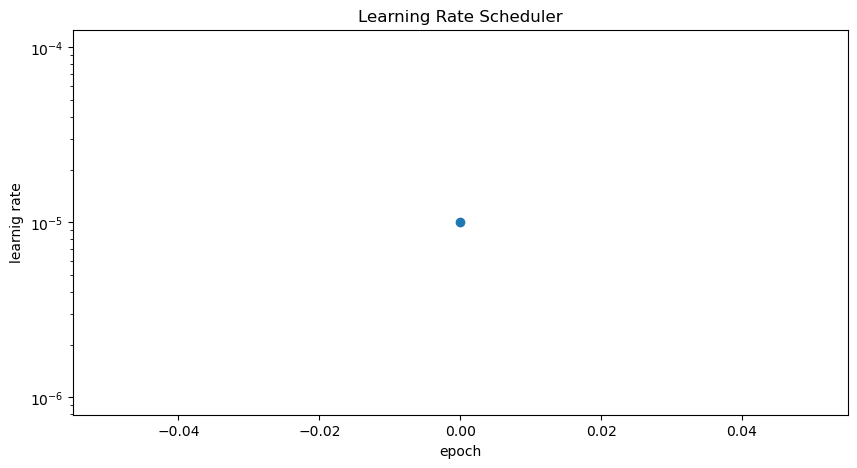

In [62]:
# the optimal lr is 10^-5 ish
def get_lr_callback(batch_size=8, plot=False):

    min     = 10 ** 5
   
    def lrfn(epoch):

        lr = 1 / (min ** (epoch+1))

        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.yscale('log')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(CFG.batch_size, plot=True )

### Train model

In [63]:


for fold in np.arange(CFG.folds):

    train_df = df.query("fold!=@fold")
    valid_df = df.query("fold==@fold")

    train_paths  = train_df.image_path.values
    train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths  = valid_df.image_path.values
    valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths   = test_df.image_path.values

    K.clear_session()

    model = build_model(CFG.model_name, dim=CFG.img_size)

    train_ds = build_dataset(train_paths, train_labels)
    valid_ds = build_dataset(valid_paths, valid_labels)

    ## save best model after each fold
    save = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5'%fold, monitor='val_loss', 
                                              verbose=1, save_best_only=True,
                                              save_weights_only=False, mode='min', save_freq='epoch')
    
    logs='./logs/fit/' + datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs, update_freq='epoch')
    
    callbacks_list = []
    callbacks_list.append(save)
    callbacks_list.append(get_lr_callback(CFG.batch_size))
    callbacks_list.append(tensorboard_callback)

    history = model.fit(train_ds, validation_data = valid_ds, 
                        epochs=CFG.epochs, steps_per_epoch=None, 
                        callbacks = callbacks_list, max_queue_size=1, verbose=1)
                        
    best_epoch = np.argmin(history.history['val_loss'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
    best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
    best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
    best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
    best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

    best_acc = np.mean([best_acc_bowel, best_acc_extra, best_acc_liver, best_acc_kidney, best_acc_spleen])
    print(f'FOLD {fold} RESULTS')
    print(f'BEST Loss  : {best_loss:.3f}\nBEST Acc   : {best_acc:.3f}\nBEST Epoch : {best_epoch}')
    print(f'Bowel : {best_acc_bowel:.3f}')
    print(f'Extravasation : {best_acc_extra:.3f}')
    print(f'Liver: {best_acc_liver:.3f}')
    print(f'Kidney: {best_acc_kidney:.3f}')
    print(f'Spleen: {best_acc_spleen:.3f}\n')

gc.collect()


>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1507/1507 [==============================] - ETA: 0s - loss: 2.8800 - bowel_loss: 0.5828 - extra_loss: 0.5235 - liver_loss: 0.4578 - kidney_loss: 0.5597 - spleen_loss: 0.7563 - bowel_accuracy: 0.6795 - extra_accuracy: 0.7380 - liver_accuracy: 0.8725 - kidney_accuracy: 0.7936 - spleen_accuracy: 0.6857
Epoch 1: val_loss improved from inf to 2.15767, saving model to fold-0.h5


/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1507/1507 [==============================] - 1498s 940ms/step - loss: 2.8800 - bowel_loss: 0.5828 - extra_loss: 0.5235 - liver_loss: 0.4578 - kidney_loss: 0.5597 - spleen_loss: 0.7563 - bowel_accuracy: 0.6795 - extra_accuracy: 0.7380 - liver_accuracy: 0.8725 - kidney_accuracy: 0.7936 - spleen_accuracy: 0.6857 - val_loss: 2.1577 - val_bowel_loss: 0.7273 - val_extra_loss: 0.3996 - val_liver_loss: 0.4170 - val_kidney_loss: 0.2225 - val_spleen_loss: 0.3913 - val_bowel_accuracy: 0.5432 - val_extra_accuracy: 0.8751 - val_liver_accuracy: 0.8939 - val_kidney_accuracy: 0.9428 - val_spleen_accuracy: 0.9043 - lr: 1.0000e-05
FOLD 0 RESULTS
BEST Loss  : 2.158
BEST Acc   : 0.832
BEST Epoch : 0
Bowel : 0.543
Extravasation : 0.875
Liver: 0.894
Kidney: 0.943
Spleen: 0.904

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1497/1497 [==============================] - ETA: 0s - loss: 2.8715 - bowel_loss: 0.6061 - extra_loss: 0.5104 - liver_loss: 0.4242 - kidney_loss: 0.

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1497/1497 [==============================] - 1780s 1s/step - loss: 2.8715 - bowel_loss: 0.6061 - extra_loss: 0.5104 - liver_loss: 0.4242 - kidney_loss: 0.5701 - spleen_loss: 0.7606 - bowel_accuracy: 0.6672 - extra_accuracy: 0.7528 - liver_accuracy: 0.8916 - kidney_accuracy: 0.7879 - spleen_accuracy: 0.6709 - val_loss: 3.0628 - val_bowel_loss: 0.7937 - val_extra_loss: 0.6085 - val_liver_loss: 0.9089 - val_kidney_loss: 0.2163 - val_spleen_loss: 0.5352 - val_bowel_accuracy: 0.5283 - val_extra_accuracy: 0.7118 - val_liver_accuracy: 0.6859 - val_kidney_accuracy: 0.9856 - val_spleen_accuracy: 0.8636 - lr: 1.0000e-05
FOLD 1 RESULTS
BEST Loss  : 3.063
BEST Acc   : 0.755
BEST Epoch : 0
Bowel : 0.528
Extravasation : 0.712
Liver: 0.686
Kidney: 0.986
Spleen: 0.864

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1516/1516 [==============================] - ETA: 0s - loss: 2.8461 - bowel_loss: 0.5793 - extra_loss: 0.4839 - liver_loss: 0.4700 - kidney_loss: 0.544

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1516/1516 [==============================] - 1744s 1s/step - loss: 2.8461 - bowel_loss: 0.5793 - extra_loss: 0.4839 - liver_loss: 0.4700 - kidney_loss: 0.5441 - spleen_loss: 0.7689 - bowel_accuracy: 0.6912 - extra_accuracy: 0.7701 - liver_accuracy: 0.8600 - kidney_accuracy: 0.8018 - spleen_accuracy: 0.6672 - val_loss: 2.8185 - val_bowel_loss: 0.6204 - val_extra_loss: 0.4774 - val_liver_loss: 0.4775 - val_kidney_loss: 0.4368 - val_spleen_loss: 0.8065 - val_bowel_accuracy: 0.7066 - val_extra_accuracy: 0.7772 - val_liver_accuracy: 0.9127 - val_kidney_accuracy: 0.9328 - val_spleen_accuracy: 0.6181 - lr: 1.0000e-05
FOLD 2 RESULTS
BEST Loss  : 2.819
BEST Acc   : 0.789
BEST Epoch : 0
Bowel : 0.707
Extravasation : 0.777
Liver: 0.913
Kidney: 0.933
Spleen: 0.618

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1530/1530 [==============================] - ETA: 0s - loss: 2.8589 - bowel_loss: 0.5941 - extra_loss: 0.5179 - liver_loss: 0.4465 - kidney_loss: 0.559

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1530/1530 [==============================] - 1745s 1s/step - loss: 2.8589 - bowel_loss: 0.5941 - extra_loss: 0.5179 - liver_loss: 0.4465 - kidney_loss: 0.5597 - spleen_loss: 0.7408 - bowel_accuracy: 0.6674 - extra_accuracy: 0.7396 - liver_accuracy: 0.8726 - kidney_accuracy: 0.8016 - spleen_accuracy: 0.6932 - val_loss: 2.4138 - val_bowel_loss: 0.7551 - val_extra_loss: 0.5070 - val_liver_loss: 0.2632 - val_kidney_loss: 0.3684 - val_spleen_loss: 0.5201 - val_bowel_accuracy: 0.5161 - val_extra_accuracy: 0.7683 - val_liver_accuracy: 0.9678 - val_kidney_accuracy: 0.9356 - val_spleen_accuracy: 0.8494 - lr: 1.0000e-05
FOLD 3 RESULTS
BEST Loss  : 2.414
BEST Acc   : 0.807
BEST Epoch : 0
Bowel : 0.516
Extravasation : 0.768
Liver: 0.968
Kidney: 0.936
Spleen: 0.849

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1404/1404 [==============================] - ETA: 0s - loss: 2.8108 - bowel_loss: 0.5819 - extra_loss: 0.5089 - liver_loss: 0.4936 - kidney_loss: 0.516

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1404/1404 [==============================] - 1438s 964ms/step - loss: 2.8108 - bowel_loss: 0.5819 - extra_loss: 0.5089 - liver_loss: 0.4936 - kidney_loss: 0.5163 - spleen_loss: 0.7102 - bowel_accuracy: 0.6886 - extra_accuracy: 0.7542 - liver_accuracy: 0.8528 - kidney_accuracy: 0.8210 - spleen_accuracy: 0.7232 - val_loss: 3.7522 - val_bowel_loss: 0.7454 - val_extra_loss: 0.3905 - val_liver_loss: 0.2372 - val_kidney_loss: 0.8339 - val_spleen_loss: 1.5454 - val_bowel_accuracy: 0.5715 - val_extra_accuracy: 0.8279 - val_liver_accuracy: 0.9972 - val_kidney_accuracy: 0.7196 - val_spleen_accuracy: 0.3771 - lr: 1.0000e-05
FOLD 4 RESULTS
BEST Loss  : 3.752
BEST Acc   : 0.699
BEST Epoch : 0
Bowel : 0.572
Extravasation : 0.828
Liver: 0.997
Kidney: 0.720
Spleen: 0.377

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1520/1520 [==============================] - ETA: 0s - loss: 2.8414 - bowel_loss: 0.6142 - extra_loss: 0.5240 - liver_loss: 0.4535 - kidney_loss: 0.

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1520/1520 [==============================] - 1634s 1s/step - loss: 2.8414 - bowel_loss: 0.6142 - extra_loss: 0.5240 - liver_loss: 0.4535 - kidney_loss: 0.5362 - spleen_loss: 0.7136 - bowel_accuracy: 0.6557 - extra_accuracy: 0.7435 - liver_accuracy: 0.8737 - kidney_accuracy: 0.8067 - spleen_accuracy: 0.7004 - val_loss: 3.9762 - val_bowel_loss: 0.7532 - val_extra_loss: 0.6468 - val_liver_loss: 0.5604 - val_kidney_loss: 0.4174 - val_spleen_loss: 1.5983 - val_bowel_accuracy: 0.4596 - val_extra_accuracy: 0.6503 - val_liver_accuracy: 0.8772 - val_kidney_accuracy: 0.8655 - val_spleen_accuracy: 0.4164 - lr: 1.0000e-05
FOLD 5 RESULTS
BEST Loss  : 3.976
BEST Acc   : 0.654
BEST Epoch : 0
Bowel : 0.460
Extravasation : 0.650
Liver: 0.877
Kidney: 0.865
Spleen: 0.416

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1462/1462 [==============================] - ETA: 0s - loss: 2.6794 - bowel_loss: 0.5785 - extra_loss: 0.4843 - liver_loss: 0.4111 - kidney_loss: 0.503

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1462/1462 [==============================] - 1713s 1s/step - loss: 2.6794 - bowel_loss: 0.5785 - extra_loss: 0.4843 - liver_loss: 0.4111 - kidney_loss: 0.5035 - spleen_loss: 0.7021 - bowel_accuracy: 0.6866 - extra_accuracy: 0.7670 - liver_accuracy: 0.8903 - kidney_accuracy: 0.8378 - spleen_accuracy: 0.7152 - val_loss: 5.1094 - val_bowel_loss: 0.5818 - val_extra_loss: 0.8262 - val_liver_loss: 0.9131 - val_kidney_loss: 1.4164 - val_spleen_loss: 1.3719 - val_bowel_accuracy: 0.7252 - val_extra_accuracy: 0.5541 - val_liver_accuracy: 0.7434 - val_kidney_accuracy: 0.5329 - val_spleen_accuracy: 0.3346 - lr: 1.0000e-05
FOLD 6 RESULTS
BEST Loss  : 5.109
BEST Acc   : 0.578
BEST Epoch : 0
Bowel : 0.725
Extravasation : 0.554
Liver: 0.743
Kidney: 0.533
Spleen: 0.335

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1462/1462 [==============================] - ETA: 0s - loss: 2.8238 - bowel_loss: 0.6075 - extra_loss: 0.5127 - liver_loss: 0.4626 - kidney_loss: 0.507

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1462/1462 [==============================] - 1873s 1s/step - loss: 2.8238 - bowel_loss: 0.6075 - extra_loss: 0.5127 - liver_loss: 0.4626 - kidney_loss: 0.5077 - spleen_loss: 0.7334 - bowel_accuracy: 0.6630 - extra_accuracy: 0.7531 - liver_accuracy: 0.8795 - kidney_accuracy: 0.8192 - spleen_accuracy: 0.6907 - val_loss: 3.2497 - val_bowel_loss: 0.7053 - val_extra_loss: 0.5494 - val_liver_loss: 0.4011 - val_kidney_loss: 0.7539 - val_spleen_loss: 0.8401 - val_bowel_accuracy: 0.6030 - val_extra_accuracy: 0.6596 - val_liver_accuracy: 0.8196 - val_kidney_accuracy: 0.6808 - val_spleen_accuracy: 0.6770 - lr: 1.0000e-05
FOLD 7 RESULTS
BEST Loss  : 3.250
BEST Acc   : 0.688
BEST Epoch : 0
Bowel : 0.603
Extravasation : 0.660
Liver: 0.820
Kidney: 0.681
Spleen: 0.677

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1508/1508 [==============================] - ETA: 0s - loss: 2.8650 - bowel_loss: 0.5926 - extra_loss: 0.5135 - liver_loss: 0.4770 - kidney_loss: 0.552

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1508/1508 [==============================] - 1895s 1s/step - loss: 2.8650 - bowel_loss: 0.5926 - extra_loss: 0.5135 - liver_loss: 0.4770 - kidney_loss: 0.5527 - spleen_loss: 0.7291 - bowel_accuracy: 0.6717 - extra_accuracy: 0.7516 - liver_accuracy: 0.8643 - kidney_accuracy: 0.7981 - spleen_accuracy: 0.6983 - val_loss: 2.7388 - val_bowel_loss: 0.4719 - val_extra_loss: 0.6154 - val_liver_loss: 0.2858 - val_kidney_loss: 0.3218 - val_spleen_loss: 1.0439 - val_bowel_accuracy: 0.8002 - val_extra_accuracy: 0.6530 - val_liver_accuracy: 0.9611 - val_kidney_accuracy: 0.9369 - val_spleen_accuracy: 0.6299 - lr: 1.0000e-05
FOLD 8 RESULTS
BEST Loss  : 2.739
BEST Acc   : 0.796
BEST Epoch : 0
Bowel : 0.800
Extravasation : 0.653
Liver: 0.961
Kidney: 0.937
Spleen: 0.630

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1506/1506 [==============================] - ETA: 0s - loss: 2.9139 - bowel_loss: 0.5971 - extra_loss: 0.5166 - liver_loss: 0.4827 - kidney_loss: 0.570

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1506/1506 [==============================] - 1601s 980ms/step - loss: 2.9139 - bowel_loss: 0.5971 - extra_loss: 0.5166 - liver_loss: 0.4827 - kidney_loss: 0.5706 - spleen_loss: 0.7468 - bowel_accuracy: 0.6654 - extra_accuracy: 0.7474 - liver_accuracy: 0.8596 - kidney_accuracy: 0.7944 - spleen_accuracy: 0.6810 - val_loss: 2.5683 - val_bowel_loss: 0.5995 - val_extra_loss: 0.4923 - val_liver_loss: 0.3372 - val_kidney_loss: 0.4172 - val_spleen_loss: 0.7221 - val_bowel_accuracy: 0.6825 - val_extra_accuracy: 0.7474 - val_liver_accuracy: 0.9495 - val_kidney_accuracy: 0.8856 - val_spleen_accuracy: 0.6990 - lr: 1.0000e-05
FOLD 9 RESULTS
BEST Loss  : 2.568
BEST Acc   : 0.793
BEST Epoch : 0
Bowel : 0.682
Extravasation : 0.747
Liver: 0.949
Kidney: 0.886
Spleen: 0.699

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1500/1500 [==============================] - ETA: 0s - loss: 2.8640 - bowel_loss: 0.6077 - extra_loss: 0.5230 - liver_loss: 0.4565 - kidney_loss: 0.

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 1518s 939ms/step - loss: 2.8640 - bowel_loss: 0.6077 - extra_loss: 0.5230 - liver_loss: 0.4565 - kidney_loss: 0.5626 - spleen_loss: 0.7142 - bowel_accuracy: 0.6589 - extra_accuracy: 0.7403 - liver_accuracy: 0.8794 - kidney_accuracy: 0.7991 - spleen_accuracy: 0.7059 - val_loss: 3.3785 - val_bowel_loss: 0.8198 - val_extra_loss: 0.4820 - val_liver_loss: 0.5362 - val_kidney_loss: 0.3547 - val_spleen_loss: 1.1858 - val_bowel_accuracy: 0.4574 - val_extra_accuracy: 0.7140 - val_liver_accuracy: 0.8335 - val_kidney_accuracy: 0.9236 - val_spleen_accuracy: 0.5220 - lr: 1.0000e-05
FOLD 10 RESULTS
BEST Loss  : 3.379
BEST Acc   : 0.690
BEST Epoch : 0
Bowel : 0.457
Extravasation : 0.714
Liver: 0.833
Kidney: 0.924
Spleen: 0.522

>>>> Load pretrained from: /Users/makoto/.keras/models/efficientnetv2-b0-imagenet.h5
1489/1489 [==============================] - ETA: 0s - loss: 2.8102 - bowel_loss: 0.5952 - extra_loss: 0.5078 - liver_loss: 0.4487 - kidney_loss: 0

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1489/1489 [==============================] - 1519s 939ms/step - loss: 2.8102 - bowel_loss: 0.5952 - extra_loss: 0.5078 - liver_loss: 0.4487 - kidney_loss: 0.5096 - spleen_loss: 0.7489 - bowel_accuracy: 0.6765 - extra_accuracy: 0.7501 - liver_accuracy: 0.8835 - kidney_accuracy: 0.8198 - spleen_accuracy: 0.6806 - val_loss: 3.8227 - val_bowel_loss: 0.7906 - val_extra_loss: 0.6871 - val_liver_loss: 0.5354 - val_kidney_loss: 1.2151 - val_spleen_loss: 0.5945 - val_bowel_accuracy: 0.5820 - val_extra_accuracy: 0.5604 - val_liver_accuracy: 0.8351 - val_kidney_accuracy: 0.6234 - val_spleen_accuracy: 0.7901 - lr: 1.0000e-05
FOLD 11 RESULTS
BEST Loss  : 3.823
BEST Acc   : 0.678
BEST Epoch : 0
Bowel : 0.582
Extravasation : 0.560
Liver: 0.835
Kidney: 0.623
Spleen: 0.790



229550

### Process prediction values

In [64]:
def mc_proc(pred):
    argmax = np.argmax(pred, axis=1).astype('uint8')
    one_hot = tf.keras.utils.to_categorical(argmax, num_classes=3)
    return one_hot.astype('uint8')

def sc_proc(pred, thr=0.5):
    proc_pred = (pred > thr).astype('uint8')
    return proc_pred

def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype='float32')

    proc_pred[:, 0] = 1 - pred[:, 0] # bowel-healthy
    proc_pred[:, 1] = pred[:, 0] # bowel-injured
    proc_pred[:, 2] = 1 - pred[:, 1] # extra-healthy
    proc_pred[:, 3] = pred[:, 1] # extra-injured
    
    proc_pred[:, 4:7] = pred[:, 2:5] # liver
    proc_pred[:, 7:10] = pred[:, 5:8] # kidney
    proc_pred[:, 10:13] = pred[:, 8:11] # spleen

    return proc_pred

### Model configs

In [65]:
CKPT_DIRS = [
    ([512, 512], './'),
]

MODEL_CONFIGS = []
for img_size, ckpt_dir in  CKPT_DIRS:
    paths = sorted(glob(os.path.join(ckpt_dir, '*h5')))[0:CFG.folds]
    if len(paths)==0:
        print('no model found for :',base_dir)
    MODEL_CONFIGS.append([img_size, paths])
display(MODEL_CONFIGS)

[[[512, 512],
  ['./fold-0.h5',
   './fold-1.h5',
   './fold-10.h5',
   './fold-11.h5',
   './fold-2.h5',
   './fold-3.h5',
   './fold-4.h5',
   './fold-5.h5',
   './fold-6.h5',
   './fold-7.h5',
   './fold-8.h5',
   './fold-9.h5']]]

### Infer

In [66]:
patient_ids = test_df['patient_id'].unique()

patient_ids.sort()

patient_preds = np.zeros(shape=(len(patient_ids), 2*2 + 3*3), dtype='float32')

preds = np.zeros(shape=(1, 11), dtype=np.float32)

for pidx, patient_id in tqdm(enumerate(patient_ids)):

    patient_df = test_df[test_df['patient_id'] != patient_id]

    model_preds = np.zeros(shape=(1, 11), dtype=np.float32)

    print(f'Patient ID: {patient_id}')

    for midx, (img_size, fold_paths) in enumerate(MODEL_CONFIGS):

        patient_paths = patient_df.image_path.tolist()

        min_batchsize = len(patient_paths)
        CFG.batch_size = min(min_batchsize, CFG.batch_size)

        dtest = build_dataset(patient_paths, batch_size=CFG.batch_size, repeat=False, 
                             shuffle=False, augment=False, cache=False,
                             decode_fn=build_decoder(with_labels=False, target_size=CFG.img_size),)
        
        for fold_path in fold_paths:
            
            model = tf.keras.models.load_model(fold_path, compile=False)
             
            pred = model.predict(dtest, verbose=1)
            pred = np.concatenate(pred, axis=-1).astype('float32')
            pred = pred[:len(patient_paths), :]
            pred = np.mean(pred.reshape(1, len(patient_paths), 11), axis=0)
            pred = np.max(pred, axis=0) # taking max prediction of all ct scans for a patient

            model_preds += pred / (len(fold_paths)*len(MODEL_CONFIGS))
                                   
            del model, pred; gc.collect()
        
        del dtest, patient_paths; gc.collect()

        patient_preds[pidx, :] += post_proc(model_preds)[0]

    del model_preds; gc.collect()


0it [00:00, ?it/s]

Patient ID: 48843
1/1 [==============================] - 21s 21s/step


1it [05:04, 304.35s/it]

Patient ID: 50046
1/1 [==============================] - 26s 26s/step


2it [10:17, 309.30s/it]

Patient ID: 63706
1/1 [==============================] - 26s 26s/step


3it [16:04, 321.52s/it]


In [67]:
patient_preds

array([[0.5458455 , 0.4541545 , 0.11233634, 0.88766366, 0.8934605 ,
        0.12604623, 0.15690951, 0.9013015 , 0.1393682 , 0.10346083,
        0.4178285 , 0.22781527, 0.4688345 ],
       [0.3074121 , 0.6925879 , 0.11977011, 0.8802299 , 0.9573862 ,
        0.12604623, 0.15690951, 0.92021054, 0.1393682 , 0.10346083,
        0.6393991 , 0.19708446, 0.4655798 ],
       [0.3074121 , 0.6925879 , 0.09516788, 0.9048321 , 0.9573862 ,
        0.04913692, 0.05740261, 0.9316267 , 0.07571246, 0.04006547,
        0.6393991 , 0.23334488, 0.36830035]], dtype=float32)

In [68]:
test_df

,image_path,patient_id,series_id,instance_number
0,./Dataset/test_images/50046/24574/30.png,50046,24574,30
1,./Dataset/test_images/63706/39279/30.png,63706,39279,30
2,./Dataset/test_images/48843/62825/30.png,48843,62825,30


### Create submission

In [69]:
pred_df = pd.DataFrame({'patient_id':patient_ids,})

sub_df = pd.read_csv('./sample_submission.csv')
pred_df = pred_df.merge(sub_df, on='patient_id', how='right')

for i, row in enumerate(patient_preds):
    pred_df.loc[i, 'bowel_healthy'] = row[0]
    pred_df.loc[i, 'bowel_injury'] = row[1]
    pred_df.loc[i, 'extravasation_healthy'] = row[2]
    pred_df.loc[i, 'extravasation_injury'] = row[3]
    pred_df.loc[i, 'kidney_healthy'] = row[4]
    pred_df.loc[i, 'kidney_low'] = row[5]
    pred_df.loc[i, 'kidney_high'] = row[6]
    pred_df.loc[i, 'liver_healthy'] = row[7]
    pred_df.loc[i, 'liver_low'] = row[8]
    pred_df.loc[i, 'liver_high'] = row[9]
    pred_df.loc[i, 'spleen_healthy'] = row[10]
    pred_df.loc[i, 'spleen_low'] = row[11]
    pred_df.loc[i, 'spleen_high'] = row[12]

pred_df.to_csv('submission.csv', index=False)


In [70]:
pred_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.545846,0.454154,0.112336,0.887664,0.893461,0.126046,0.156910,0.901302,0.139368,0.103461,0.417829,0.227815,0.468834
1,50046,0.307412,0.692588,0.119770,0.880230,0.957386,0.126046,0.156910,0.920211,0.139368,0.103461,0.639399,0.197084,0.465580
2,63706,0.307412,0.692588,0.095168,0.904832,0.957386,0.049137,0.057403,0.931627,0.075712,0.040065,0.639399,0.233345,0.368300
